In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def com_distance_to_pmf(file, bins):
    """Load COM distance as a function of MC steps and calculate potential of mean force (PMF)"""
    p, r = np.histogram(np.loadtxt(file), bins=bins)
    r = r[1:] / 2 + r[0:-1] / 2
    dr = r[1] - r[0]
    r_max = r[-1]
    gofr = p / p.sum() * r_max / dr  # g(r)
    pmf = -np.log(gofr)  # w(r)/kT
    print(f"r_min = {r[0]}, r_max = {r_max} Å, dr = {dr} Å")
    return r, pmf


def virtual_translate_to_pmf(distance_file, vt_file, bins, ref_r=None, ref_pmf=None):
    """
    Calculate PMF by integrating the mean force from VirtualTranslate.

    The mean force at each R is obtained by binning exp(-dU/kT) by COM distance,
    then: force(R) = ln(<exp(-dU/kT)>) / dL. Integrating gives the PMF.

    Samples with extreme dU/kT (where exp(-dU) overflows to inf) are excluded
    before binning; these correspond to rare overlap configurations.

    If ref_r and ref_pmf are given, the VT PMF is shifted to match the
    reference in the overlap region (useful since cumulative integration
    only determines the PMF up to an additive constant).
    """
    from scipy.stats import binned_statistic

    R = np.loadtxt(distance_file)
    _step, dL, du, _force = np.loadtxt(vt_file, unpack=True, skiprows=1)
    n = min(len(R), len(du))
    if len(R) != len(du):
        print(
            f"Warning: length mismatch (R={len(R)}, vt={len(du)}), using last {n} rows"
        )
        R, du, dL = R[-n:], du[-n:], dL[-n:]
    boltzmann = np.exp(-du)
    valid = np.isfinite(boltzmann)
    if not valid.all():
        print(
            f"VirtualTranslate: filtered {(~valid).sum()} / {len(valid)} non-finite samples"
        )
    means, edges, _ = binned_statistic(R[valid], boltzmann[valid], "mean", bins)
    r = (edges[:-1] + edges[1:]) / 2
    force = np.log(means) / dL[0]
    dr = np.median(np.diff(r))
    pmf = -np.cumsum(force) * dr

    if ref_r is not None and ref_pmf is not None:
        # Shift VT PMF to match reference in the overlap region
        ref_interp = np.interp(r, ref_r, ref_pmf)
        shift = np.nanmean(ref_interp - pmf)
        pmf += shift
    else:
        pmf -= pmf[-1]  # fallback: normalize so PMF -> 0 at large R
    return r, pmf

r_min = 38.571275, r_max = 105.549725 Å, dr = 0.6765499999999918 Å


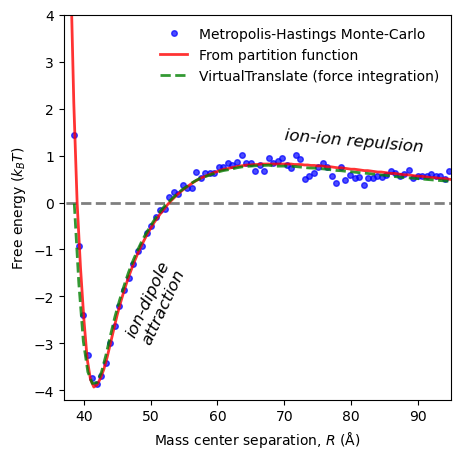

In [5]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 5))
r, pmf = com_distance_to_pmf("com_distance.dat.gz", bins=100)
ax.hlines(0, xmin=r[0] - 10, xmax=r[-1] + 10, color="k", alpha=0.5, ls="--", lw=2)
ax.plot(
    r, pmf - 0.7, "bo", lw=3, label="Metropolis-Hastings Monte-Carlo", alpha=0.7, ms=4
)

r_ref, pmf_ref = np.loadtxt("virialize-pmf.dat", usecols=[0, 1], unpack=True)
ax.plot(r_ref, pmf_ref, label="From partition function", lw=2, alpha=0.8, color="red")

r_vt, pmf_vt = virtual_translate_to_pmf(
    "com_distance.dat.gz", "vt.dat.gz", bins=100, ref_r=r_ref, ref_pmf=pmf_ref
)
ax.plot(
    r_vt, pmf_vt, "g--", lw=2, label="VirtualTranslate (force integration)", alpha=0.8
)

ax.set_ylabel("Free energy ($k_BT$)")
ax.set_xlabel("Mass center separation, $R$ (Å)")
ax.legend(loc=0, frameon=False)
ax.set_xlim(37, 95)
ax.set_ylim(-4.2, 4)
ax.text(70, 1.1, "ion-ion repulsion", rotation=-5, fontstyle="italic", fontsize="large")
ax.text(
    46, -3, "ion-dipole\nattraction", rotation=65, fontstyle="italic", fontsize="large"
)
plt.savefig("twobody.png", bbox_inches="tight", dpi=300)
plt.show()